# 2017 QHP Individual Market Dental Insurance

Data from [healthcare.gov](https://data.healthcare.gov/dataset/2017-QHP-Landscape-Individual-Market-Dental/gwq7-ribq). 

# Imports and Load Data

In [1]:
!pip install vega_datasets

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

# US map datasets
from vega_datasets import data

# train-test split
from sklearn.model_selection import train_test_split

# linear regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR

# cross val, k-folds, scaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# ignore warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=Warning)
print('Warnings will be ignored!')

Warnings will be ignored!


In [3]:
# enable altair visualizations
alt.renderers.enable()
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

# Population Stats

In [4]:
# population stats df
pop_df = pd.read_csv('US_Population_Density_by_State.csv')
pop_df.columns = ['State', 'State Code', 'StateID_Geo', 'Pop Density', 'Population', 'Area']

pop_df['Pop Density'] = pop_df['Pop Density'].str.replace(',', '')
pop_df['Pop Density'] = pop_df['Pop Density'].astype('uint32')

pop_df['Population'] = pop_df['Population'].str.replace(',', '')
pop_df['Population'] = pop_df['Population'].astype('uint32')

pop_df['Area'] = pop_df['Area'].str.replace(',', '')
pop_df['Area'] = pop_df['Area'].astype('uint32')

In [5]:
# dictionary for state names and codes for visualizations
state_geo_dict = pd.Series(pop_df.State.values,index=pop_df['StateID_Geo']).to_dict()

In [6]:
state_geo_dict

{11: 'District of Columbia',
 34: 'New Jersey',
 44: 'Rhode Island',
 25: 'Massachusetts',
 9: 'Connecticut',
 24: 'Maryland',
 10: 'Delaware',
 36: 'New York',
 12: 'Florida',
 42: 'Pennsylvania',
 39: 'Ohio',
 6: 'California',
 17: 'Illinois',
 15: 'Hawaii',
 51: 'Virginia',
 37: 'North Carolina',
 18: 'Indiana',
 13: 'Georgia',
 26: 'Michigan',
 45: 'South Carolina',
 47: 'Tennessee',
 33: 'New Hampshire',
 21: 'Kentucky',
 53: 'Washington',
 48: 'Texas',
 22: 'Louisiana',
 55: 'Wisconsin',
 1: 'Alabama',
 29: 'Missouri',
 54: 'West Virginia',
 27: 'Minnesota',
 50: 'Vermont',
 28: 'Mississippi',
 4: 'Arizona',
 5: 'Arkansas',
 19: 'Iowa',
 40: 'Oklahoma',
 8: 'Colorado',
 41: 'Oregon',
 23: 'Maine',
 49: 'Utah',
 20: 'Kansas',
 32: 'Nevada',
 31: 'Nebraska',
 16: 'Idaho',
 35: 'New Mexico',
 46: 'South Dakota',
 38: 'North Dakota',
 30: 'Montana',
 56: 'Wyoming',
 2: 'Alaska'}

# Data Cleaning + Feature Engineering

In [7]:
# load data
df = pd.read_csv('2017_QHP_Landscape_Individual_Market_Dental.csv')

# remove child only offerings
df = df[df['Child Only Offering'] == 'Allows Adult and Child-Only']

# encode state names by frequency
state_list = df['State Code'].value_counts().index.tolist()

state_dict = dict()
for x in range(0, (len(state_list))):
    state_dict[state_list[x]] = x
      
df['StateID'] = df['State Code'].map(state_dict).astype('uint8')

# state value counts
df['StateFreq'] = df['State Code'].map(df['State Code'].value_counts())

# merge with population data
df = pd.merge(df, pop_df, on='State Code')

# drop features with all nulls and unneeded features
df = df.drop(['Premium Rates', 'Standard On Exchange', 'Child Only Offering'], axis=1)

# drop phone number features
df = df.drop(['Customer Service Phone Number Local', 'Customer Service Phone Number Toll Free', 
             'Customer Service Phone Number TTY'], axis=1)

# reset index
df = df.reset_index(drop=True)

# county changed to county + state code
df['County Name'] = df['County Name'] + " " + df['State Code']

# encode county names by frequency
county_list = df['County Name'].value_counts().index.tolist()

county_dict = dict()
for x in range(0, (len(county_list))):
    county_dict[county_list[x]] = x
    
df['CountyID'] = df['County Name'].map(county_dict).astype('uint16')

# encode issuers by frequency
issuer_list = df['Issuer Name'].value_counts().index.tolist()

issuer_dict = dict()
for x in range(0, (len(issuer_list))):
    issuer_dict[issuer_list[x]] = x
    
df['IssuerID'] = df['Issuer Name'].map(issuer_dict).astype('uint16')

# encode marketing plans
marketing_plan_list = df['Plan Marketing Name']

marekting_plan_dict = dict()
for x in range(0, (len(marketing_plan_list))):
    marekting_plan_dict[marketing_plan_list[x]] = x
    
df['PlanMarketingID'] = df['Plan Marketing Name'].map(marekting_plan_dict).astype('uint16')

# encode plan IDs
plan_id_list = df['Plan ID (Standard Component)']

plan_id_dict = dict()
for x in range(0, (len(plan_id_list))):
    plan_id_dict[plan_id_list[x]] = x
    
df['PlanID Encoded'] = df['Plan ID (Standard Component)'].map(plan_id_dict).astype('uint16')

# 'Metal Level' turned into binomial
# considering changing name to 'Hi Metal Level'
df['Metal Level'] = df['Metal Level'].replace('Low', 0)
df['Metal Level'] = df['Metal Level'].replace('High', 1)
df['Metal Level'] = df['Metal Level'].astype('uint8')

# turn 'Rating Area' into numeric value
df['Rating Area'] = df['Rating Area'].str.replace('Rating Area ', '').astype('uint16')

# replace nulls in coverage categories
df['Routine Dental Services - Adult (Coverage)'] = df['Routine Dental Services - Adult (Coverage)'].fillna(0)
df['Basic Dental Care - Adult (Coverage)'] = df['Basic Dental Care - Adult (Coverage)'].fillna(0)
df['Major Dental Care - Adult (Coverage)'] = df['Major Dental Care - Adult (Coverage)'].fillna(0)
df['Orthodontia - Adult (Coverage)'] = df['Orthodontia - Adult (Coverage)'].fillna(0)
df['Dental Check-Up for Children (Coverage)'] = df['Dental Check-Up for Children (Coverage)'].fillna(0)
df['Basic Dental Care - Child (Coverage)'] = df['Basic Dental Care - Child (Coverage)'].fillna(0)
df['Major Dental Care - Child (Coverage)'] = df['Major Dental Care - Child (Coverage)'].fillna(0)
df['Orthodontia - Child (Coverage)'] = df['Orthodontia - Child (Coverage)'].fillna(0)

# turn coverage categories into binomials
df['Routine Dental Services - Adult (Coverage)'] = df['Routine Dental Services - Adult (Coverage)'].replace('X', 1)
df['Basic Dental Care - Adult (Coverage)'] = df['Basic Dental Care - Adult (Coverage)'].replace('X', 1)
df['Major Dental Care - Adult (Coverage)'] = df['Major Dental Care - Adult (Coverage)'].replace('X', 1)
df['Orthodontia - Adult (Coverage)'] = df['Orthodontia - Adult (Coverage)'].replace('X', 1)
df['Dental Check-Up for Children (Coverage)'] = df['Dental Check-Up for Children (Coverage)'].replace('X', 1)
df['Basic Dental Care - Child (Coverage)'] = df['Basic Dental Care - Child (Coverage)'].replace('X', 1)
df['Major Dental Care - Child (Coverage)'] = df['Major Dental Care - Child (Coverage)'].replace('X', 1)
df['Orthodontia - Child (Coverage)'] = df['Orthodontia - Child (Coverage)'].replace('X', 1)

# convert coverage categories into 'uint8' data type
df['Routine Dental Services - Adult (Coverage)'] = df['Routine Dental Services - Adult (Coverage)'].astype('uint8')
df['Basic Dental Care - Adult (Coverage)'] = df['Basic Dental Care - Adult (Coverage)'].astype('uint8')
df['Major Dental Care - Adult (Coverage)'] = df['Major Dental Care - Adult (Coverage)'].astype('uint8')
df['Orthodontia - Adult (Coverage)'] = df['Orthodontia - Adult (Coverage)'].astype('uint8')
df['Dental Check-Up for Children (Coverage)'] = df['Dental Check-Up for Children (Coverage)'].astype('uint8')
df['Basic Dental Care - Child (Coverage)'] = df['Basic Dental Care - Child (Coverage)'].astype('uint8')
df['Major Dental Care - Child (Coverage)'] = df['Major Dental Care - Child (Coverage)'].astype('uint8')
df['Orthodontia - Child (Coverage)'] = df['Orthodontia - Child (Coverage)'].astype('uint8')

# remove dollar signs and turn into 'uint16' / impute 'Not Applicable' values with .quantile(q=0.75) 
# NA does not mean zero; it typically means multiple deductibles; so expect higher than average

df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].str.replace('$', '')
df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].str.replace(' ', '')
df['Dental Deductible - Family (Per Person) - Standard'] = pd.to_numeric(df['Dental Deductible - Family (Per Person) - Standard'], errors='coerce')
df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].fillna(df['Dental Deductible - Family (Per Person) - Standard'].quantile(q=0.75))
df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].astype('uint16')

df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].str.replace('$', '')
df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].str.replace(' ', '')
df['Dental Deductible - Individual - Standard'] = pd.to_numeric(df['Dental Deductible - Individual - Standard'], errors='coerce')
df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].fillna(df['Dental Deductible - Individual - Standard'].quantile(q=0.75))
df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].astype('uint16')

df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].str.replace('$', '')
df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].str.replace(' ', '')
df['Dental Deductible - Family - Standard'] = pd.to_numeric(df['Dental Deductible - Family - Standard'], errors='coerce')
df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].fillna(df['Dental Deductible - Family - Standard'].quantile(q=0.75))
df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].astype('uint16')

df['Dental Maximum Out of Pocket - Individual - Standard'] = df['Dental Maximum Out of Pocket - Individual - Standard'].str.replace('$', '')
df['Dental Maximum Out of Pocket - Individual - Standard'] = df['Dental Maximum Out of Pocket - Individual - Standard'].str.replace(' ', '')
df['Dental Maximum Out of Pocket - Individual - Standard'] = df['Dental Maximum Out of Pocket - Individual - Standard'].astype('uint16')

df['Dental Maximum Out of Pocket - Family - Standard'] = df['Dental Maximum Out of Pocket - Family - Standard'].str.replace('$', '')
df['Dental Maximum Out of Pocket - Family - Standard'] = df['Dental Maximum Out of Pocket - Family - Standard'].str.replace(' ', '')
df['Dental Maximum Out of Pocket - Family - Standard'] = df['Dental Maximum Out of Pocket - Family - Standard'].astype('uint16')

df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].str.replace('$', '')
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].str.replace(' ', '')
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = pd.to_numeric(df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'], errors='coerce')
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].fillna(0)
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].astype('uint16')

# turn 'Source' into binomial
df['SERFF'] = df['Source']
df['SERFF'] = df['SERFF'].replace('HIOS', 0)
df['SERFF'] = df['SERFF'].replace('SERFF', 1)
df['SERFF'] = df['SERFF'].astype('uint8')

# create average premium per person metric as sum of all premiums divided by estimated # of individuals
df['Avg Premium'] = df[['Premium Child','Premium Adult Individual Age 21', 'Premium Adult Individual Age 27',
       'Premium Adult Individual Age 30 ', 'Premium Adult Individual Age 40 ',
       'Premium Adult Individual Age 50 ', 'Premium Adult Individual Age 60 ',
       'Premium Couple 21  ', 'Premium Couple 30 ', 'Premium Couple 40 ',
       'Premium Couple 50 ', 'Premium Couple 60 ', 'Couple+1 child, Age 21',
       'Couple+1 child, Age 30 ', 'Couple+1 child, Age 40 ',
       'Couple+1 child, Age 50 ', 'Couple+2 children, Age 21',
       'Couple+2 children, Age 30 ', 'Couple+2 children, Age 40 ',
       'Couple+2 children, Age 50', 'Couple+3 or more Children, Age 21',
       'Couple+3 or more Children, Age 30',
       'Couple+3 or more Children, Age 40',
       'Couple+3 or more Children, Age 50', 'Individual+1 child, Age 21',
       'Individual+1 child, Age 30', 'Individual+1 child, Age 40',
       'Individual+1 child, Age 50', 'Individual+2 children, Age 21',
       'Individual+2 children, Age 30', 'Individual+2 children, Age 40',
       'Individual+2 children, Age 50',
       'Individual+3 or more children, Age 21',
       'Individual+3 or more children, Age 30',
       'Individual+3 or more children, Age 40',
       'Individual+3 or more children, Age 50',]].sum(axis = 1, skipna = True) / 101

# insurance plans per capita; measure of competition
df['PlansPer100K'] = (df['StateFreq'] / df['Population']) * 100000

def mean_premium_map(feature):
    mean_premium = df.groupby(feature, as_index=True)['Avg Premium'].mean()
    mean_premium_dict = dict(zip(mean_premium.index, mean_premium))
    return mean_premium_dict

# mean premium per provider
df['Issuer_MP'] = df['IssuerID'].map(mean_premium_map(df['IssuerID'])).astype('float32')

# mean premium by state
df['State_MP'] = df['StateID'].map(mean_premium_map(df['StateID'])).astype('float32')

# mean premium by county
df['County_MP'] = df['CountyID'].map(mean_premium_map(df['CountyID'])).astype('float32')

# mean premium by rating area
df['RatingArea_MP'] = df['Rating Area'].map(mean_premium_map(df['Rating Area'])).astype('float32')

# mean premium by plans per capita
df['PlansPer100K_MP'] = df['PlansPer100K'].map(mean_premium_map(df['PlansPer100K'])).astype('float32')

# mean premium by marketing id
df['MarketingID_MP'] = df['PlanMarketingID'].map(mean_premium_map(df['PlanMarketingID'])).astype('float32')

# mean premium by pop density
df['PopDensity_MP'] = df['Pop Density'].map(mean_premium_map(df['Pop Density'])).astype('float32')

# pop density bins
df['PopDensityBins'] = pd.qcut(df['Pop Density'], q=11, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], duplicates='drop')

# mean premium by pop density bucket
df['PopDensityBin_MP'] = df['PopDensityBins'].map(mean_premium_map(df['PopDensityBins'])).astype('float32')


# drop some redundant columns
df = df.drop(['Source'], axis=1)


In [8]:
# # print value counts for all 'objects'
# def object_vcs_and_nulls(df):
#   for i in df:
#     if df[i].dtype == 'O':
# #       if df[i].isnull().sum() > 0:
#         print(df[i].value_counts())  
#         print("Number of Null Values: " + str(df[i].isnull().sum()))
#         print("Percentage of Nulls = " + str(np.round((df[i].isnull().sum() / df.shape[0] * 100), 2)) + "%")
#         print("\n")
      
# object_vcs_and_nulls(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40646 entries, 0 to 40645
Data columns (total 91 columns):
State Code                                                       40646 non-null object
FIPS County Code                                                 40646 non-null int64
County Name                                                      40646 non-null object
Metal Level                                                      40646 non-null uint8
Issuer Name                                                      40646 non-null object
HIOS Issuer ID                                                   40646 non-null int64
Plan ID (Standard Component)                                     40646 non-null object
Plan Marketing Name                                              40646 non-null object
Plan Type                                                        40646 non-null object
Rating Area                                                      40646 non-null uint16
Routine Dental Services 

# Create Visualization Dataframes

In [10]:
# function to generate new dataframes for stats
def feature_by_premium(feature):

    new_df = pd.DataFrame()
       
    avg_prem_state = df.groupby(feature, as_index=True)['Avg Premium'].mean()
    new_df['avg_prem'] = avg_prem_state
    
    new_df['id'] = new_df.index    
  
    return new_df

In [11]:
state_prem_df = feature_by_premium('StateID_Geo')
state_prem_df = state_prem_df.reindex(list(range(state_prem_df.index.min(),state_prem_df.index.max()+1)),fill_value=np.nan)
state_prem_df['id'] = state_prem_df.index.astype('uint16')
state_prem_df['state'] = state_prem_df['id'].map(state_geo_dict)

In [12]:
state_prem_df

,avg_prem,id,state
StateID_Geo,,,
1,24.666,1,Alabama
2,51.935,2,Alaska
3,nan,3,NaN
4,29.909,4,Arizona
5,27.296,5,Arkansas
6,nan,6,California
7,nan,7,NaN
8,nan,8,Colorado
9,nan,9,Connecticut


In [13]:
county_prem_df = feature_by_premium('FIPS County Code')
county_prem_df.head()

,avg_prem,id
FIPS County Code,,
1001,24.580,1001
1003,24.660,1003
1005,24.660,1005
1007,24.881,1007
1009,24.881,1009


# Visualizations - Maps

* [Choropleth Maps Altair](https://www.districtdatalabs.com/altair-choropleth-viz)

Note: These images will not render on Github.

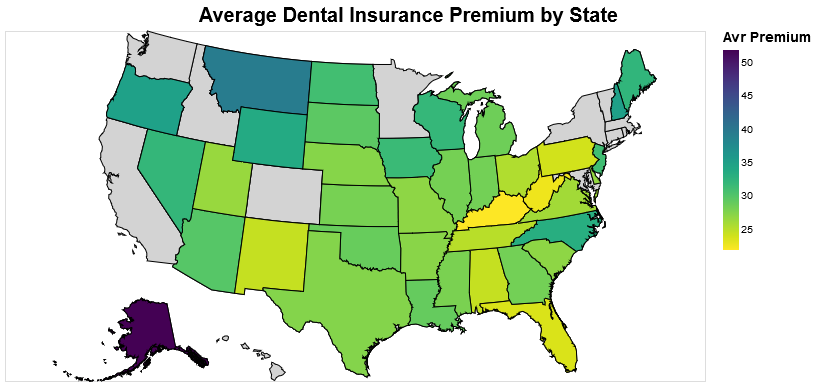

In [14]:
states = alt.topo_feature(data.us_10m.url, 'states')
source = state_prem_df

foreground = alt.Chart(states).mark_geoshape(stroke='black').encode(
    color=alt.Color('avg_prem:Q', sort="descending",  scale=alt.Scale(scheme='viridis'), legend=alt.Legend(title="Avr Premium", tickCount=6))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['avg_prem'])
).project(
    type='albersUsa'
).properties(
    title="Average Dental Insurance Premium by State", 
    width=700,
    height=350
)  


background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='black'
).properties(
    width=700,
    height=350
).project('albersUsa')

config = alt.layer(background, foreground).configure_title(fontSize=20, anchor="middle").configure_legend(titleColor='black', titleFontSize=14) 

config

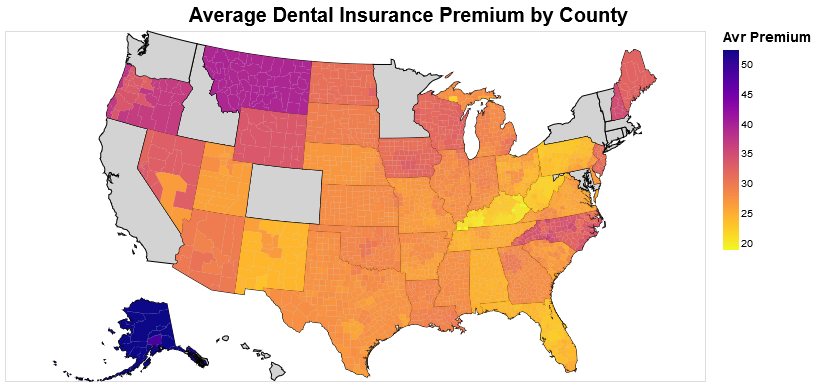

In [15]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
county_source = county_prem_df

foreground = alt.Chart(counties).mark_geoshape(
    ).encode(
    color=alt.Color('avg_prem:Q', sort="descending",  scale=alt.Scale(scheme='plasma'), legend=alt.Legend(title="Avr Premium", tickCount=6))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(county_source, 'id', ['avg_prem'])
).project(
    type='albersUsa'
).properties(
    title="Average Dental Insurance Premium by County",
    width=500,
    height=300
)

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='black'
).properties(
    width=700,
    height=350
).project('albersUsa')

config = alt.layer(background, foreground).configure_title(fontSize=20, anchor="middle").configure_legend(titleColor='black', titleFontSize=14) 

config

# Visualizations - Charts

In [23]:
df.columns

Index(['State Code', 'FIPS County Code', 'County Name', 'Metal Level',
       'Issuer Name', 'HIOS Issuer ID', 'Plan ID (Standard Component)',
       'Plan Marketing Name', 'Plan Type', 'Rating Area',
       'Routine Dental Services - Adult (Coverage)',
       'Basic Dental Care - Adult (Coverage)',
       'Major Dental Care - Adult (Coverage)',
       'Orthodontia - Adult (Coverage)',
       'Dental Check-Up for Children (Coverage)',
       'Basic Dental Care - Child (Coverage)',
       'Major Dental Care - Child (Coverage)',
       'Orthodontia - Child (Coverage)', 'Premium Child',
       'Premium Adult Individual Age 21', 'Premium Adult Individual Age 27',
       'Premium Adult Individual Age 30 ', 'Premium Adult Individual Age 40 ',
       'Premium Adult Individual Age 50 ', 'Premium Adult Individual Age 60 ',
       'Premium Couple 21  ', 'Premium Couple 30 ', 'Premium Couple 40 ',
       'Premium Couple 50 ', 'Premium Couple 60 ', 'Couple+1 child, Age 21',
       'Couple+1 child,

In [24]:
# issuer dataframe
inv_issuer_dict = pd.Series(df['Issuer Name'].values,index=df['IssuerID']).to_dict()
issuer_prem_df = feature_by_premium('IssuerID')
issuer_prem_df = issuer_prem_df[:20]
issuer_prem_df['Issuer Name'] = issuer_prem_df['id'].map(inv_issuer_dict)
issuer_prem_df = issuer_prem_df.sort_values('avg_prem')

In [25]:
issuer_prem_order_list = issuer_prem_df['Issuer Name'].tolist()
issuer_prem_order_list

['Dominion Dental Services, Inc.',
 'Humana Insurance Company',
 'Alpha Dental Programs, Inc.',
 'DentaQuest USA Insurance Company, Inc.',
 'Blue Cross and Blue Shield of Georgia, Inc.',
 'Dental Care Plus, Inc.',
 'DSM USA Insurance Company, Inc.',
 'Guardian Life Insurance Company of America',
 'Cigna Health and Life Insurance Company',
 'Blue Cross Blue Shield of Texas',
 'DSM USA Insurance Company Inc',
 'The Guardian Life Insurance Company',
 'Delta Dental of Nebraska',
 'Educators Health Plans Life, Accident, and Health,',
 'Delta Dental Insurance Company',
 'Renaissance Life & Health Insurance Company of America',
 'Dentegra Insurance Company',
 'BEST Life and Health Insurance Company',
 'Delta Dental of Minnesota',
 'TRUASSURE INSURANCE COMPANY']

In [26]:
pop_density_dict = {0: '0 - 37', 1: '37 - 58', 2: '58 - 90', 3: '90 - 110', 4: '110 - 165', 5: '165 - 185', 
                    6: '185 - 210', 7: '210 - 220', 8: '220 - 286', 9: '286+'}

pop_density_order_list = list(pop_density_dict.values())

pop_density_df = feature_by_premium('PopDensityBins')
pop_density_df['bin'] = pop_density_df['id'].map(pop_density_dict)
pop_density_df

,avg_prem,id,bin
PopDensityBins,,,
0,30.574,0,0 - 37
1,30.410,1,37 - 58
2,27.144,2,58 - 90
3,28.016,3,90 - 110
4,23.983,4,110 - 165
5,28.363,5,165 - 185
6,28.309,6,185 - 210
7,27.819,7,210 - 220
8,26.608,8,220 - 286


In [27]:
# set seaborn style to white background
sns.set(style="white")

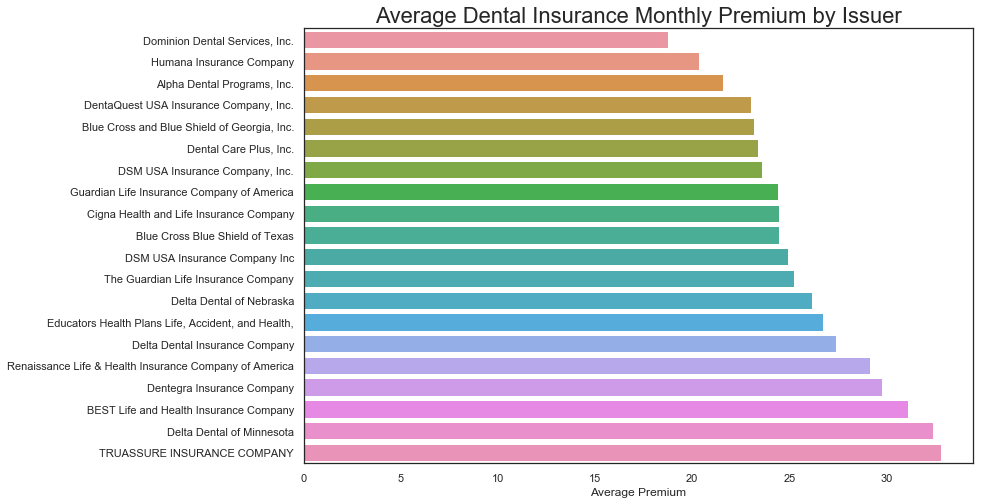

In [28]:
# average dental insurance nontly premium sorted by least expensive
plt.figure(figsize=(12,8))
sns.barplot(y='Issuer Name', x='avg_prem', data=issuer_prem_df.sort_values('avg_prem', ascending = True));

plt.ylabel('')
plt.xlabel('Average Premium')
plt.title('Average Dental Insurance Monthly Premium by Issuer', fontsize=22);

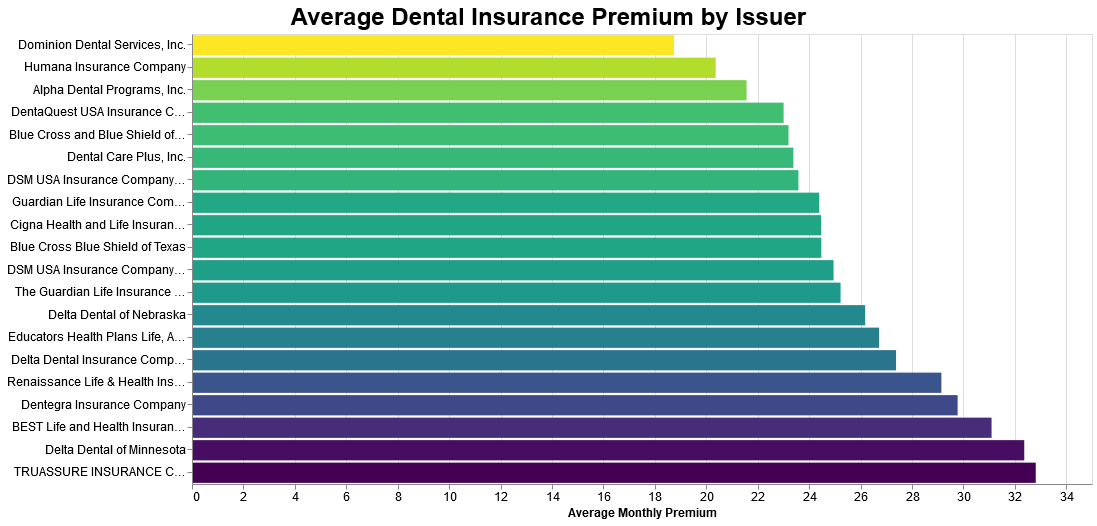

In [29]:
bar = alt.Chart(issuer_prem_df, title='Average Dental Insurance Premium by Issuer', height=450, width=900).configure_title(fontSize=24).mark_bar().encode(
        x = 'avg_prem', 
        y = alt.Y('Issuer Name', sort=issuer_prem_order_list),
        color = alt.Color('avg_prem', sort="descending", legend=None, scale=alt.Scale(scheme='viridis'))).configure_axis(
    labelFontSize=12,
    titleFontSize=12
)

bar.encoding.x.title = 'Average Monthly Premium'
bar.encoding.y.title = ''
bar

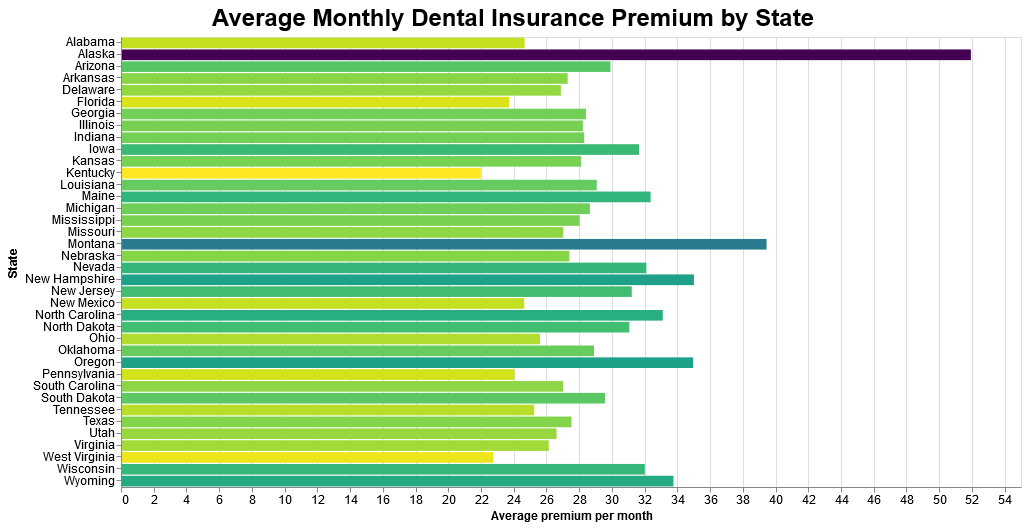

In [30]:
bar = alt.Chart(state_prem_df, title='Average Monthly Dental Insurance Premium by State', height=450, width=900).configure_title(fontSize=24).mark_bar().encode(
        x = 'avg_prem', 
        y = 'state',
        color = alt.Color('avg_prem', sort="descending", legend=None, scale=alt.Scale(scheme='viridis'))).configure_axis(
    labelFontSize=12,
    titleFontSize=12
)

bar.encoding.x.title = 'Average premium per month'
bar.encoding.y.title = 'State'
bar

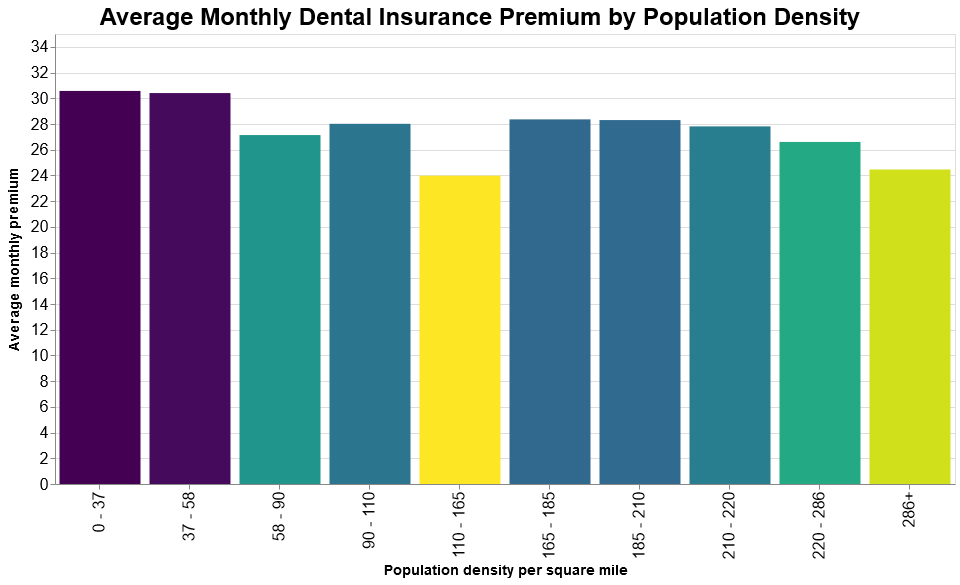

In [31]:
bar = alt.Chart(pop_density_df, title='Average Monthly Dental Insurance Premium by Population Density', height=450, width=900).configure_title(fontSize=24).mark_bar().encode(
        x = alt.X('bin', sort=pop_density_order_list),  
        y = 'avg_prem',
        color = alt.Color('avg_prem', legend=None, sort="descending", scale=alt.Scale(scheme='viridis') )).configure_axis(
    labelFontSize=16,
    titleFontSize=14
)

bar.encoding.x.title = 'Population density per square mile'
bar.encoding.y.title = 'Average monthly premium'
bar

In [32]:
# find correlations between average premium and other metrics
num_df = df._get_numeric_data()
num_df = num_df[['Avg Premium', 'StateFreq', 'StateID_Geo', 'Pop Density', 'Population',
       'Area', 'CountyID', 'IssuerID', 'PlanMarketingID', 'PlanID Encoded',
       'SERFF', 'PlansPer100K', 'Issuer_MP', 'State_MP',
       'County_MP', 'RatingArea_MP', 'PlansPer100K_MP', 'MarketingID_MP',
       'PopDensity_MP', 'PopDensityBin_MP']]

corr = num_df.corr()

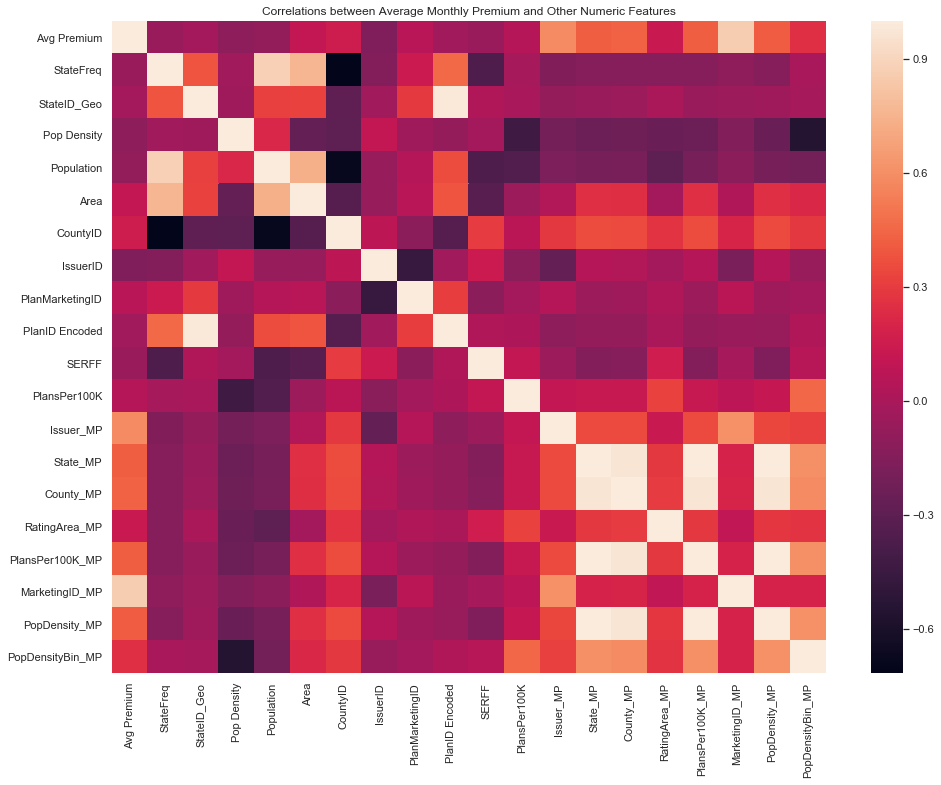

In [33]:
plt.figure(figsize = (16,12))
plt.title("Correlations between Average Monthly Premium and Other Numeric Features")
sns.heatmap(corr);

# Models

In [34]:
# shuffle data for cross_val_score; function scores poor w/o it
shuffle_df = df.reindex(np.random.permutation(df.index))

# created modified dataframe of only numeric values
mod_df = shuffle_df._get_numeric_data()

# eliminate features with near 100% correlation with y-var
mod_df = mod_df.drop(['Premium Child',
       'Premium Adult Individual Age 21', 'Premium Adult Individual Age 27',
       'Premium Adult Individual Age 30 ', 'Premium Adult Individual Age 40 ',
       'Premium Adult Individual Age 50 ', 'Premium Adult Individual Age 60 ',
       'Premium Couple 21  ', 'Premium Couple 30 ', 'Premium Couple 40 ',
       'Premium Couple 50 ', 'Premium Couple 60 ', 'Couple+1 child, Age 21',
       'Couple+1 child, Age 30 ', 'Couple+1 child, Age 40 ',
       'Couple+1 child, Age 50 ', 'Couple+2 children, Age 21',
       'Couple+2 children, Age 30 ', 'Couple+2 children, Age 40 ',
       'Couple+2 children, Age 50', 'Couple+3 or more Children, Age 21',
       'Couple+3 or more Children, Age 30',
       'Couple+3 or more Children, Age 40',
       'Couple+3 or more Children, Age 50', 'Individual+1 child, Age 21',
       'Individual+1 child, Age 30', 'Individual+1 child, Age 40',
       'Individual+1 child, Age 50', 'Individual+2 children, Age 21',
       'Individual+2 children, Age 30', 'Individual+2 children, Age 40',
       'Individual+2 children, Age 50',
       'Individual+3 or more children, Age 21',
       'Individual+3 or more children, Age 30',
       'Individual+3 or more children, Age 40',
       'Individual+3 or more children, Age 50'], axis=1)

In [35]:
mod_df.columns

Index(['FIPS County Code', 'Metal Level', 'HIOS Issuer ID', 'Rating Area',
       'Routine Dental Services - Adult (Coverage)',
       'Basic Dental Care - Adult (Coverage)',
       'Major Dental Care - Adult (Coverage)',
       'Orthodontia - Adult (Coverage)',
       'Dental Check-Up for Children (Coverage)',
       'Basic Dental Care - Child (Coverage)',
       'Major Dental Care - Child (Coverage)',
       'Orthodontia - Child (Coverage)',
       'Dental Deductible - Individual - Standard',
       'Dental Deductible - Family - Standard',
       'Dental Deductible - Family (Per Person) - Standard',
       'Dental Maximum Out of Pocket - Individual - Standard',
       'Dental Maximum Out of Pocket - Family - Standard',
       'Dental Maximum Out of Pocket - Family (Per Person) - Standard',
       'StateID', 'StateFreq', 'StateID_Geo', 'Pop Density', 'Population',
       'Area', 'CountyID', 'IssuerID', 'PlanMarketingID', 'PlanID Encoded',
       'SERFF', 'Avg Premium', 'PlansPer100K',

In [36]:
X = mod_df.drop(['Avg Premium'], axis=1)
y = mod_df['Avg Premium']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [38]:
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_pred, y_test) : 
    if len(y_test) == len(y_pred):
        return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))
      
# Root mean squared error (RMSE)
def rmse(y_pred, y_test):
  return np.sqrt(mean_squared_error(y_test, y_pred))

In [39]:
# Linear Regression
lm = LinearRegression()
model_lm = lm.fit(X_train,y_train)
pred_lm = lm.predict(X_test)
result_lm = model_lm.score(X_test, y_test)
cv_scores_lm = cross_val_score(lm, X, y, cv=5, scoring='neg_mean_squared_log_error')
lm_rmsle = np.sqrt(np.abs(cv_scores_lm.mean()))

print("=== Linear Regression ===")
print("R2: " + str(result_lm))
print("RMSLE: " + str(rmsle(pred_lm, y_test)))
print("RMSE: " + str(rmse(pred_lm, y_test)))
print("Mean RMSLE Score: ", lm_rmsle.mean())
print("\n")

# # Random Forest Regression
rfr = RandomForestRegressor()
model_rfr = rfr.fit(X_train,y_train)
pred_rfr = rfr.predict(X_test)
result_rfr = model_rfr.score(X_test, y_test)
cv_scores_rfr = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_log_error')
rfr_rmsle = np.sqrt(np.abs(cv_scores_rfr.mean()))


print("=== Random Forest Regression ===")
print("R2: " + str(result_rfr))
print("RMSLE: " + str(rmsle(pred_rfr, y_test)))
print("RMSE: " + str(rmse(pred_rfr, y_test)))
print("Mean RMSLE Score: ", rfr_rmsle.mean())
print("\n")

# Extra Trees Regression
etr = ExtraTreesRegressor()
model_etr = etr.fit(X_train,y_train)
pred_etr = etr.predict(X_test)
result_etr = model_etr.score(X_test, y_test)
cv_scores_etr = cross_val_score(etr, X, y, cv=5, scoring='neg_mean_squared_log_error')
etr_rmsle = np.sqrt(np.abs(cv_scores_etr.mean()))

print("=== Extra Trees Regression ===")
print("R2: " + str(result_etr))
print("RMSLE: " + str(rmsle(pred_etr, y_test)))
print("RMSE: " + str(rmse(pred_etr, y_test)))
print("Mean RMSLE Score: ", etr_rmsle.mean())
print("\n")

=== Linear Regression ===
R2: 0.8573233576834057
RMSLE: 0.10091792933973855
RMSE: 2.8417113635733777
Mean RMSLE Score:  0.10107218528418777


=== Random Forest Regression ===
R2: 0.9966284943753448
RMSLE: 0.017097606804110564
RMSE: 0.43683302907884713
Mean RMSLE Score:  0.016713019175490756


=== Extra Trees Regression ===
R2: 0.9977792495975321
RMSLE: 0.01420019085757003
RMSE: 0.35453033296604664
Mean RMSLE Score:  0.013131686752060242




In [40]:
# feature importance of random forest model
rf_fi=RandomForestRegressor()
rf_fi.fit(X, y)
FI_rf = pd.DataFrame({"Feature Importance":rf_fi.feature_importances_}, index=X.columns)
FI_rf_sorted = FI_rf.sort_values("Feature Importance",ascending=False)
print(FI_rf_sorted.to_string())

                                                    Feature Importance
MarketingID_MP                                                   0.722
County_MP                                                        0.051
Issuer_MP                                                        0.031
PopDensity_MP                                                    0.025
PlanID Encoded                                                   0.025
Population                                                       0.019
State_MP                                                         0.017
Metal Level                                                      0.017
PlansPer100K_MP                                                  0.014
HIOS Issuer ID                                                   0.012
IssuerID                                                         0.010
PlanMarketingID                                                  0.009
CountyID                                                         0.007
Pop De